In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
PROJECT_ROOT = "/raid/data/cellpainting/TAORF/"
EXP = "inc_nikita"
num_features = 7680

In [4]:
meta = pd.read_csv(os.path.join(PROJECT_ROOT, "outputs/compressed/metadata/compressed.csv"))

In [5]:
def fraction_strong_test(treatment_corr, null, num_treatments):
    null.sort()
    p95 = null[ int( 0.95*len(null) ) ]
    fraction = np.sum([m > p95 for m in treatment_corr])/num_treatments
    print("Treatments tested:", num_treatments)
    print("At 95th percentile of the null")
    print("Fraction strong: {:5.2f}%".format(fraction*100))
    print("Null threshold: {:6.4f}".format(p95))

# Load single cell data

In [6]:
if not os.path.isfile("well_level_data.csv"):
    features = []
    for i in tqdm(meta.index):
        filename = PROJECT_ROOT + "outputs/" + EXP + "/features/{}_{}_{}.npz"
        filename = filename.format(
            meta.loc[i, "Metadata_Plate"], 
            meta.loc[i, "Metadata_Well"], 
            meta.loc[i, "Metadata_Site"]
        )
        if os.path.isfile(filename):
            with open(filename, "rb") as data:
                info = np.load(data)
                features.append(info["f"])
        else:
            features.append([])

In [7]:
if not os.path.isfile("well_level_data.csv"):
    total_single_cells = 0
    for i in range(len(features)):
        if len(features[i]) > 0:
            total_single_cells += features[i].shape[0]

    print("Total images",len(features),features[0].shape)
    print("Total single cells:", total_single_cells)

# Aggregate into site-level profiles

In [8]:
if not os.path.isfile("well_level_data.csv"):
    site_level_data = []
    site_level_features = []
    for plate in tqdm(meta["Metadata_Plate"].unique()):
        m1 = meta["Metadata_Plate"] == plate
        wells = meta[m1]["Metadata_Well"].unique()
        for well in wells:
            result = meta.query("Metadata_Plate == '{}' and Metadata_Well == '{}'".format(plate, well))
            for i in result.index:
                if len(features[i]) == 0:
                    continue
                num_features = features[i].shape[1]
                mean_profile = features[i].mean(axis=0)
                gene_name = result["gene_name"].unique()
                replicate = result["gene_name_Replicate"].unique()
                if len(gene_name) > 1:
                    print(gene_name)
                site_level_data.append(
                    {
                        "Plate": plate,
                        "Well": well,
                        "Gene": gene_name[0],
                        "Replicate": replicate[0]
                    }
                )
                site_level_features.append(mean_profile)

In [9]:
if not os.path.isfile("well_level_data.csv"):
    columns1 = ["Plate", "Well", "Gene", "Replicate"]
    columns2 = [i for i in range(num_features)]
    
    sites1 = pd.DataFrame(columns=columns1, data=site_level_data)
    sites2 = pd.DataFrame(columns=columns2, data=site_level_features)
    sites = pd.concat([sites1, sites2], axis=1)
else:
    columns2 = [str(i) for i in range(num_features)]

# Aggregate into well-level profiles

In [10]:
# Collapse well data
if not os.path.isfile("well_level_data.csv"):
    wells = sites.groupby(["Plate", "Well", "Gene"]).mean().reset_index()
    wells.to_csv("well_level_data.csv", index=False)
else:
    wells = pd.read_csv("well_level_data.csv")

In [11]:
# Attach gene names to the dataframe
gene_ids = pd.read_csv("labels.csv")
gene_names = gene_ids.Treatment.str.split("@", expand=True)
gene_names.columns = ["Number", "Gene_Name"]
gene_names["ID"] = gene_names.index
genes = pd.merge(gene_ids, gene_names, on="ID")

wells = pd.merge(wells, genes, left_on="Gene", right_on="ID")

# Replicate correlation of treatments

In [12]:
CRM = np.corrcoef(wells[columns2])
controls = ["EMPTY", "eGFP", "Luciferase", "LacZ"]

In [13]:
# Compute replicate correlation on treated wells
replicate_correlations = []
treatments = [x for x in wells.Gene_Name.unique() if x not in controls]

for gene in treatments:
    idx = [i for i in wells[wells["Gene_Name"] == gene].index]
    rc = np.median(CRM[np.ix_(idx, idx)])
    replicate_correlations.append(rc)

In [14]:
# Compute a null distribution using random treated wells
null_distribution = []
treated_well_index = [x for x in wells[wells["Gene_Name"].isin(treatments)].index]

for k in range(1000):
    np.random.shuffle(treated_well_index)
    idx = treated_well_index[0:10]
    rc = np.median(CRM[np.ix_(idx, idx)])
    null_distribution.append(rc)

In [15]:
# Fraction of strong connections
fraction_strong_test(replicate_correlations, null_distribution, len(treatments))

Treatments tested: 190
At 95th percentile of the null
Fraction strong: 67.89%
Null threshold: 0.9908


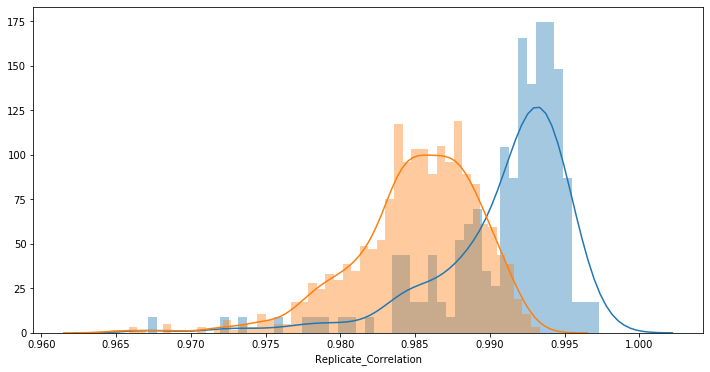

In [16]:
# Visualization of distributions
truereps = pd.DataFrame(data=replicate_correlations, columns=["Replicate_Correlation"])
null = pd.DataFrame(data=null_distribution, columns=["Replicate_Correlation"])

plt.figure(figsize=(12,6))
sb.distplot(truereps["Replicate_Correlation"], bins=50)
sb.distplot(null["Replicate_Correlation"], bins=50)

# Replicate correlation of controls

In [17]:
# Compute replicate correlation on treated wells
control_correlations = []
plates = [x for x in wells.Plate.unique()]

for plate in plates:
    for s in range(10):
        idx = [x for x in wells[wells["Gene_Name"].isin(controls)].query("Plate == " + str(plate)).index]
        np.random.shuffle(idx)
        idx = idx[0:10]
        rc = np.median(CRM[np.ix_(idx, idx)])
        control_correlations.append(rc)

In [18]:
# Compute a null distribution using random treated wells
control_null = []
control_well_index = [x for x in wells[wells["Gene_Name"].isin(controls)].index]

for k in range(1000):
    np.random.shuffle(control_well_index)
    idx = control_well_index[0:10]
    rc = np.median(CRM[np.ix_(idx, idx)])
    control_null.append(rc)

In [19]:
fraction_strong_test(control_correlations, control_null, len(plates)*10)

Treatments tested: 50
At 95th percentile of the null
Fraction strong:  6.00%
Null threshold: 0.9916


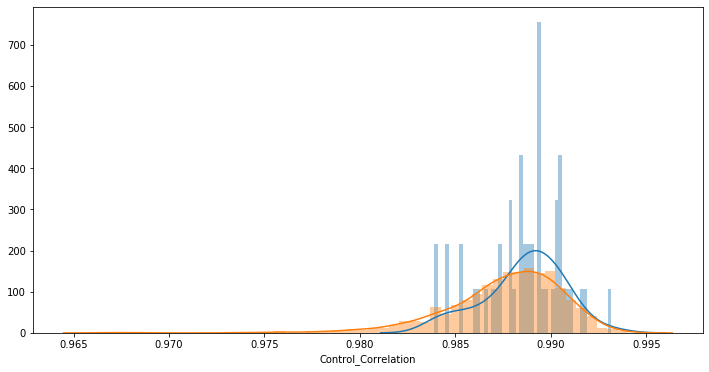

In [20]:
platereps = pd.DataFrame(data=control_correlations, columns=["Control_Correlation"])
platenull = pd.DataFrame(data=control_null, columns=["Control_Correlation"])

plt.figure(figsize=(12,6))
sb.distplot(platereps["Control_Correlation"], bins=50)
sb.distplot(platenull["Control_Correlation"], bins=50)